In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, Normalizer, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC        
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix ,classification_report
from sklearn.model_selection import StratifiedKFold, cross_validate
import time

In [21]:
dataset = pd.read_parquet('../data/processed/spotify_churn_dataset_clean.parquet')

In [22]:
categorical_features = ['gender', 'country', 'subscription_type', 'device_type']
numerical_features = ['age', 'listening_time', 'songs_played_per_day', 'skip_rate', 'ads_listened_per_week']
to_delete = ['user_id', 'offline_listening']

target = ['is_churned'] 

In [23]:
dataset = dataset.drop(columns=to_delete)

In [24]:
X = dataset.drop(columns=target, axis=1)
y = dataset[target].squeeze()

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
classifiers = [
    LogisticRegression(
        max_iter=1000, 
        C=1.0, 
        random_state=42),
    KNeighborsClassifier(
        n_neighbors=11, 
        weights='distance'),
    SVC(
        kernel='rbf', 
        C=1.0, 
        gamma='scale', 
        probability=True, 
        random_state=42),
    GaussianNB(),
    DecisionTreeClassifier(
        max_depth=10, 
        min_samples_leaf=3, 
        random_state=42),
    RandomForestClassifier(
        n_estimators=300, 
        max_features='sqrt', 
        random_state=42
        ),
    XGBClassifier(
        n_estimators=500, learning_rate=0.1, max_depth=5,
        subsample=0.8, colsample_bytree=0.8,
        tree_method='hist', eval_metric='logloss',
        random_state=42, n_jobs=-1
    ),
]


In [27]:
num_transformers = [StandardScaler()]
cat_transformers = [OneHotEncoder(drop='first', handle_unknown='ignore')]

                    model num_transformer cat_transformer  cv_accuracy_mean  \
0      LogisticRegression  StandardScaler   OneHotEncoder              0.74   
2                     SVC  StandardScaler   OneHotEncoder              0.74   
3              GaussianNB  StandardScaler   OneHotEncoder              0.74   
5  RandomForestClassifier  StandardScaler   OneHotEncoder              0.74   
1    KNeighborsClassifier  StandardScaler   OneHotEncoder              0.72   
6           XGBClassifier  StandardScaler   OneHotEncoder              0.70   
4  DecisionTreeClassifier  StandardScaler   OneHotEncoder              0.70   

   cv_precision_mean  cv_recall_mean  cv_f1_mean  cv_auc_mean  test_accuracy  \
0               0.00            0.00        0.00         0.50           0.75   
2               0.00            0.00        0.00         0.52           0.75   
3               0.00            0.00        0.00         0.49           0.75   
5               0.26            0.01        0.0

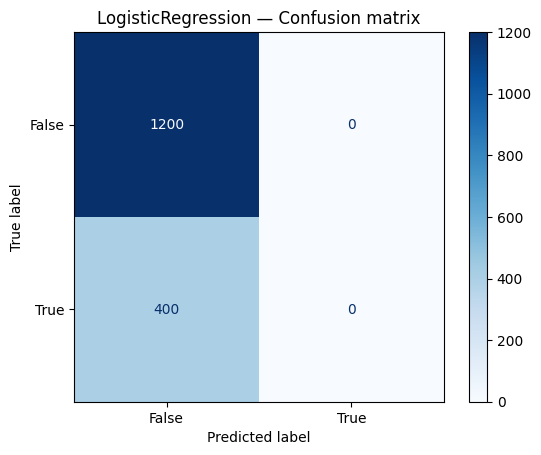


KNeighborsClassifier &  — Confusion matrix


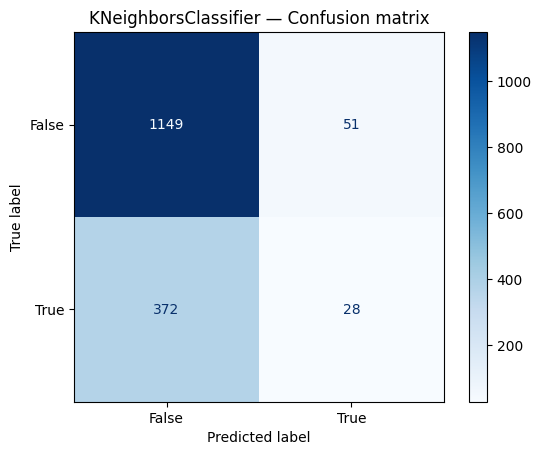


SVC &  — Confusion matrix


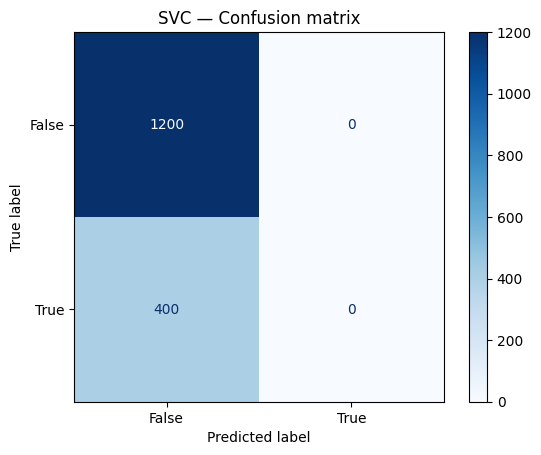


GaussianNB &  — Confusion matrix


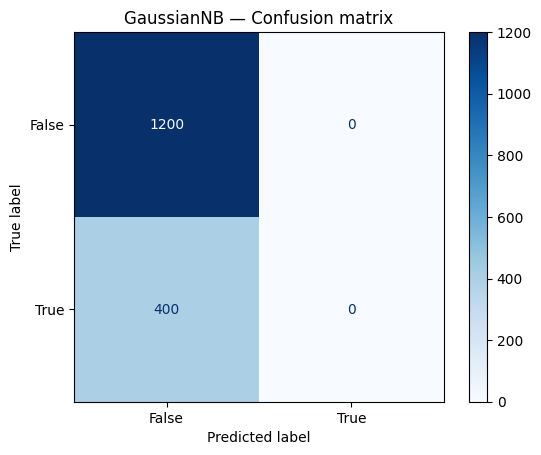


DecisionTreeClassifier &  — Confusion matrix


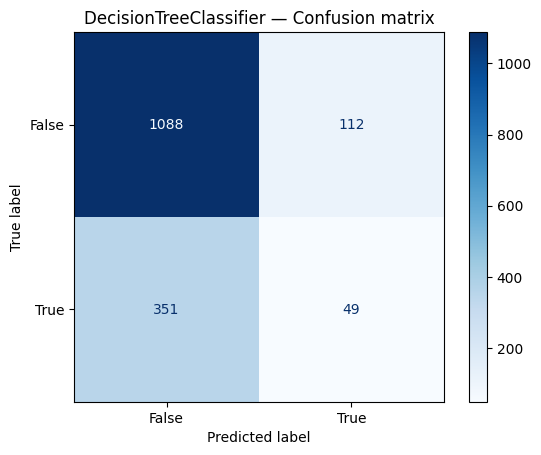


RandomForestClassifier &  — Confusion matrix


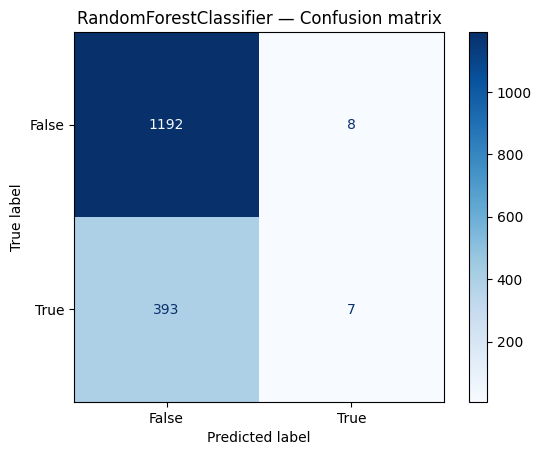


XGBClassifier &  — Confusion matrix


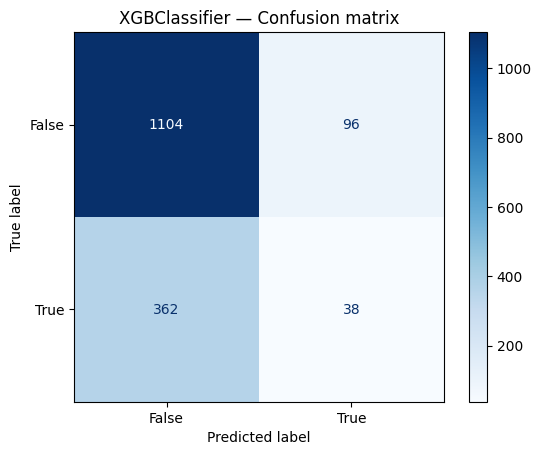

In [30]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorers = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

results = []
preds = []

for clf in classifiers:
    for num_tr in num_transformers:
        for cat_tr in cat_transformers:
            
            preprocessor = ColumnTransformer([
                ('num', num_tr, numerical_features),
                ('cat', cat_tr, categorical_features)
            ], remainder='drop')

            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('classifier', clf)
            ])
            
            cv_res = cross_validate(
                pipeline, X_train, y_train,
                cv=cv, scoring=scorers, n_jobs=-1, return_estimator=False
            )
            
            start = time.time()
            pipeline.fit(X_train, y_train)
            end = time.time()

            y_pred = pipeline.predict(X_test)
            
            preds.append((clf.__class__.__name__, y_pred))
             #ponoć jest metoda jak classification_raport która to liczy automatycznie i yellowbrick do wykresów
            acc = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            roc_auc = roc_auc_score(y_test, y_pred)

            results.append({
                'model'            : clf.__class__.__name__,
                'num_transformer'  : num_tr.__class__.__name__,
                'cat_transformer'  : cat_tr.__class__.__name__,
                # CV (średnie)
                'cv_accuracy_mean' : cv_res['test_accuracy'].mean(),
                'cv_precision_mean': cv_res['test_precision'].mean(),
                'cv_recall_mean'   : cv_res['test_recall'].mean(),
                'cv_f1_mean'       : cv_res['test_f1'].mean(),
                'cv_auc_mean'      : cv_res['test_roc_auc'].mean(),
                # TEST
                'test_accuracy'    : acc,
                'test_precision'   : precision,
                'test_recall'      : recall,
                'test_f1'          : f1,
                'test_auc'         : roc_auc,
                'train_time_s'     : round(end - start, 2),
            })

pd.set_option('display.float_format', lambda x: '%.2f' % x)
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='test_accuracy', ascending=False))

labels = np.sort(np.unique(y_test))  
for name, y_hat in preds:
    print(f"\n{name} &  — Confusion matrix")
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_hat, labels=labels,
        values_format='d',
        cmap='Blues',
    )
    plt.title(f'{name} — Confusion matrix')
    plt.show()

## Final summary

**What I found**
- The target `is_churned` is **imbalanced** (about 75% Not-churn, 25% Churn).
- Most numeric features don’t depend on each other (correlations ~0).
- From the categorical features, **subscription_type** and **device_type** have some signal; **gender** is weak.

**Data prep**
- Numbers scaled with `StandardScaler`, categories encoded with `OneHotEncoder`.
- I removed `user_id` (just an ID) and dropped `offline_listening` because it duplicates subscription/ads info.

**Models (baseline)**
- I tried: Logistic Regression, KNN, SVC, Naive Bayes, Decision Tree, Random Forest, XGBoost.
- Test **accuracy** is ~0.74–0.75 for most models — basically the same as always guessing the majority class.
- Some models predict almost only “Not-churn”. Trees/RF/XGB find a few churns, but **recall/F1 are low**.
- My AUC was ~0.5 because I calculated it from hard labels, not from probabilities (so it doesn’t show much).

**Plain takeaway**
- With my current features and settings, the models don’t beat the simple baseline. There is **some** signal, but not enough yet.

---

## What I’d try next

1. **Use probabilities** and pick a **better threshold** (not always 0.5).  
   → Compute ROC-AUC / PR-AUC from `predict_proba` and set the threshold that gives best F1 or a target recall.
2. **Handle imbalance**  
   → `class_weight="balanced"` (LR/SVC/Tree/RF) or `scale_pos_weight` in XGBoost; you can also try SMOTE/undersampling.
3. **Tidy features**  
   → Make one binary feature `has_premium` instead of mixing subscription/offline/ads.
4. **Add simple new features**  
   → last-7/30-day activity, skip ratios, days without listening, device usage share, etc.
5. **Do a light parameter search**  
   → RandomizedSearchCV for RF/XGB/SVC using AUC/PR-AUC as the scoring metric.

